In [1]:
#import keras
#from keras.datasets import cifar10
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model,Model 
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,AveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
import pandas as pd
import cv2

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


In [2]:
# Create files list ( Count total file numbers for training )
trainingset_path = r'train/'
train_file_list = []
for root, dirs, files in os.walk(trainingset_path):
    for file in files:
        f = os.path.join(root,file)
        train_file_list.append(f)

In [3]:
print('total training data:',len(train_file_list))
print(train_file_list[1])

total training data: 2985
train/bedroom\image_0002.jpg


image_shape: (256, 256)


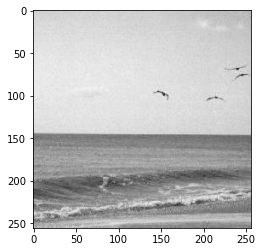

In [4]:
# Check image
img = cv2.imread(train_file_list[500], 0)
print('image_shape:',img.shape)#這裡可以看到我們透過上面的程式將圖片透過imread轉成陣列(numpy)的形式`,轉成數值後才能進行分析
plt.imshow(img, cmap="gray")#這裡則是將我們數值化後的值重新圖片化的結果

CALsuburb, 9
PARoffice, 7
bedroom, 12
coast, 10
forest, 4
highway, 14
industrial, 2
insidecity, 3
kitchen, 0
livingroom, 5
mountain, 8
opencountry, 6
store, 11
street, 1
tallbuilding, 13

In [5]:
# Class mapping by Kaggle rule
class_mapping = ['kitchen','street','industrial','insidecity','forest',
                 'livingroom','opencountry','PARoffice','mountain','CALsuburb'
                 ,'coast','store','bedroom','tallbuilding']

In [6]:
#Loading Image data from folder
image_size = 224 #設定圖片的像素大小
datagen_kaggle=ImageDataGenerator().flow_from_directory(trainingset_path,
                                                     target_size=(image_size,image_size),
                                                     classes=class_mapping,
                                                     batch_size=len(train_file_list),
                                                     shuffle=True)

Found 2825 images belonging to 14 classes.


In [7]:
datagen_kaggle_x,datagen_kaggle_y = next(datagen_kaggle)

In [8]:
# Create training & validation set
x_train,x_test,y_train,y_test = train_test_split(datagen_kaggle_x,datagen_kaggle_y,test_size=0.1)

In [9]:
# x_train.shape
# x_train[1]

In [10]:
batch_size = 64
num_classes = len(class_mapping)
epochs = 50
#save_dir = os.path.join(os.getcwd(), 'saved_models')
#model_name = 'keras_kaggle_trained_TL_Xception_model.h5'

In [11]:
# The data, shuffled and split between train and test sets:
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (2542, 224, 224, 3)
2542 train samples
283 test samples


In [12]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [13]:
#Load InceptionNet V3(Google Net) model
#vgg16_model = keras.applications.vgg16.VGG16(include_top=False,input_shape=(image_size,image_size,3))
#weight_file = 'xception_weights_tf_dim_ordering_tf_kernels_notop.h5'

model = keras.applications.EfficientNetB0(include_top=False
                                             ,input_shape=(image_size,image_size,3)
                                             ,weights = 'imagenet'
                                            ,pooling='avg'
                                            )
model.tranable = False

In [14]:
model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [15]:
#Adding custom Layers 
x = model.output
#x = GlobalAveragePooling2D()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1000, activation="relu")(x)
x = keras.layers.Dense(1000, activation="relu")(x)
#加上output Dense
predictions = keras.layers.Dense(num_classes, activation="softmax")(x)
# creating the final model 

In [16]:
#之前layer的trainable參數為False
# for layer in model.layers[:-30]:
#     layer.trainable = False
# Check the trainable status of the individual layers
# for layer in model.layers:
#     print(layer, layer.trainable)    

In [17]:
model = keras.models.Model(inputs = model.input, outputs = predictions)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

block6c_bn (BatchNormalization) (None, 7, 7, 1152)   4608        block6c_dwconv[0][0]             
__________________________________________________________________________________________________
block6c_activation (Activation) (None, 7, 7, 1152)   0           block6c_bn[0][0]                 
__________________________________________________________________________________________________
block6c_se_squeeze (GlobalAvera (None, 1152)         0           block6c_activation[0][0]         
__________________________________________________________________________________________________
block6c_se_reshape (Reshape)    (None, 1, 1, 1152)   0           block6c_se_squeeze[0][0]         
__________________________________________________________________________________________________
block6c_se_reduce (Conv2D)      (None, 1, 1, 48)     55344       block6c_se_reshape[0][0]         
__________________________________________________________________________________________________
block6c_se

In [18]:
# initiate Adam optimizer
opt = keras.optimizers.Adam(lr=1e-4)

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [19]:
x_train[1]

array([[[155., 155., 155.],
        [152., 152., 152.],
        [149., 149., 149.],
        ...,
        [201., 201., 201.],
        [200., 200., 200.],
        [200., 200., 200.]],

       [[153., 153., 153.],
        [150., 150., 150.],
        [148., 148., 148.],
        ...,
        [193., 193., 193.],
        [194., 194., 194.],
        [194., 194., 194.]],

       [[152., 152., 152.],
        [149., 149., 149.],
        [146., 146., 146.],
        ...,
        [188., 188., 188.],
        [189., 189., 189.],
        [191., 191., 191.]],

       ...,

       [[ 51.,  51.,  51.],
        [ 52.,  52.,  52.],
        [ 53.,  53.,  53.],
        ...,
        [120., 120., 120.],
        [117., 117., 117.],
        [138., 138., 138.]],

       [[ 52.,  52.,  52.],
        [ 52.,  52.,  52.],
        [ 53.,  53.,  53.],
        ...,
        [ 68.,  68.,  68.],
        [ 62.,  62.,  62.],
        [ 65.,  65.,  65.]],

       [[ 55.,  55.,  55.],
        [ 54.,  54.,  54.],
        [ 53.,  

In [20]:
#input data normalization
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255.
#x_test /= 255.

In [21]:
print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False # randomly flip images
    #zca_whitening=True, # PCA降维操作
    #zca_epsilon=1e-6 # PCA降維度參數
    )  

Using real-time data augmentation.


In [22]:
# Use ModelCheckpoint to save model and weights
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'small_data_model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = keras.callbacks.ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, verbose=1)

In [23]:
# earlystop
earlystop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, verbose=1)

In [24]:
# Fit the model on the batches generated by datagen.flow().
model_history = model.fit_generator(datagen.flow(x_train, y_train,
                                    batch_size=batch_size),
                                    epochs=epochs,
                                    validation_data=(x_test, y_test),
                                    workers=4,
                                    callbacks=[earlystop,checkpoint]
                               )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
40/40 [==============================] - ETA: 0s - loss: 1.9397 - accuracy: 0.4689
Epoch 00001: val_accuracy improved from -inf to 0.67845, saving model to C:\Users\0312449\Desktop\auo-small-data-cnn\saved_models\small_data_model.h5
40/40 [==============================] - 25s 614ms/step - loss: 1.9397 - accuracy: 0.4689 - val_loss: 1.3302 - val_accuracy: 0.6784
Epoch 2/50
40/40 [==============================] - ETA: 0s - loss: 0.7252 - accuracy: 0.7982
Epoch 00002: val_accuracy improved from 0.67845 to 0.87986, saving model to C:\Users\0312449\Desktop\auo-small-data-cnn\saved_models\small_data_model.h5
40/40 [==============================] - 23s 572ms/step - loss: 0.7252 - accuracy: 0.7982 - val_loss: 0.4574 - val_accuracy: 0.8799
Epoch 3/50
40/40 [==============================] - ETA: 0s - loss: 0.3220 - accuracy: 0.8961
Epoch 00003: val_accuracy improved from 0.87986 to 0.90106, saving model to

Epoch 25/50
40/40 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9965
Epoch 00025: val_accuracy did not improve from 0.96113
40/40 [==============================] - 22s 543ms/step - loss: 0.0147 - accuracy: 0.9965 - val_loss: 0.1586 - val_accuracy: 0.9470
Epoch 26/50
40/40 [==============================] - ETA: 0s - loss: 0.0159 - accuracy: 0.9953
Epoch 00026: val_accuracy did not improve from 0.96113
40/40 [==============================] - 21s 536ms/step - loss: 0.0159 - accuracy: 0.9953 - val_loss: 0.1655 - val_accuracy: 0.9576
Epoch 00026: early stopping


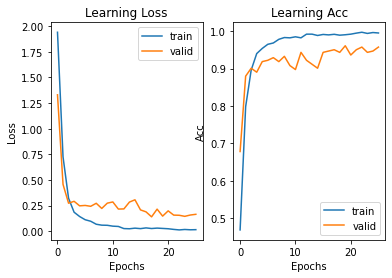

In [26]:
#draw the loss & acc

training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

training_acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

plt.figure(1)
plt.subplot(121)
plt.plot(training_loss, label="train")
plt.plot(val_loss, label="valid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Loss")
plt.legend(loc='best')

plt.subplot(122)
plt.plot(training_acc, label="train")
plt.plot(val_acc, label="valid")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Acc")
plt.legend(loc='best')

plt.show()

In [27]:
#讀入 testing data 並組成 testing data set
testset_path = r'testset/'
test_file_list = []
test_file_name = []
for root, dirs, files in os.walk(testset_path):
    for file in files:
        f = os.path.join(root,file)
        img = cv2.imread(f)
        img = cv2.resize(img,(image_size,image_size))
        img = np.expand_dims(img,axis=0)
        test_file_list.append(img)
        filename,_ = os.path.splitext(file)
        test_file_name.append(filename)

In [28]:
test_file_name = np.asarray(test_file_name)
test_file_name.shape

(1500,)

In [29]:
test_file_list[0].shape

(1, 224, 224, 3)

In [30]:
test_data = np.concatenate([x for x in test_file_list])
print(test_data.shape)

(1500, 224, 224, 3)


In [29]:
#model.summary()

In [31]:
# loading our save model
print("Loading trained model")
#model = load_model(model_path)
model.load_weights(model_path)
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Loading trained model
9/9 [==============================] - 0s 49ms/step - loss: 0.1479 - accuracy: 0.9611
Test loss: 0.14794403314590454
Test accuracy: 0.9611307382583618


In [32]:
# 把測試資料丟到 model 預測
y_result = model.predict(test_data)
final_result = np.argmax(y_result,axis=1)
print(final_result.shape)
final_result

(1500,)


array([12,  4,  4, ...,  8,  6,  3], dtype=int64)

In [33]:
#用 pandas 產出分類結果
submit = pd.DataFrame()
submit['id'] = test_file_name
submit['class'] = final_result
file_name = 'submission_efficientNet_01.csv'
submit.to_csv(file_name,index=False)

In [34]:
submit.head(5)

id  class
0  001d4c8d70ebf7f025fccf256324d3d5ad3560faee1cdf...     12
1  00317b9d4bed4a2b1017e2bd31b9bf2f25bad05a65f570...      4
2  003d15d71c1514af5bb8734a96bae2c4d1ce299da8d369...      4
3  013c78d920be5390dbc66ca238ae3f49a2b0cf13e36013...      8
4  0175d5cda7ae5f6767187eef4bc29e0be62a5506acfdcf...     10